In [20]:
using PorousMaterials
using PyPlot
using DataFrames
using CSV

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

131.293

In [21]:
path_to_exptl_isotherms = joinpath("data", "exptl_xe_isotherms")
path_to_sim_isotherms = joinpath("data","sim_xe_isotherms")

"data\\sim_xe_isotherms"

In [22]:
? get_cmap

search: get_cmap get_cmaps get_plot_commands get_current_fig_manager




    Get a colormap instance, defaulting to rc values if *name* is None.

    Colormaps added with :func:`register_cmap` take precedence over
    built-in colormaps.

    If *name* is a :class:`matplotlib.colors.Colormap` instance, it will be
    returned.

    If *lut* is not None it must be an integer giving the number of
    entries desired in the lookup table, and *name* must be a standard
    mpl colormap name.
    

In [23]:
crystal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
    "FMOF-Cu", "MOF-505", "Activated-Carbon", "COF-103"]

mof_to_marker = Dict("SBMOF-1" => "o", "CC3" => ">", "Ni-MOF-74" => "<", "HKUST-1" => "*", "SBMOF-2" => "H", 
    "Co-formate" => "^", "FMOF-Cu" => "s", "MOF-505" => "v",
    "Activated-Carbon" => "d", "COF-103" => "8")

mof_to_color = Dict(zip(crystal_names, ["C$i" for i = 1:length(crystal_names)]))# TODO MAKE UNIQUE!

Dict{String,String} with 10 entries:
  "Ni-MOF-74"        => "C3"
  "SBMOF-2"          => "C5"
  "FMOF-Cu"          => "C7"
  "CC3"              => "C2"
  "Activated-Carbon" => "C9"
  "COF-103"          => "C10"
  "SBMOF-1"          => "C1"
  "HKUST-1"          => "C4"
  "MOF-505"          => "C8"
  "Co-formate"       => "C6"

In [24]:
df_mof = Dict{String, DataFrame}()

Dict{String,DataFrame} with 0 entries

In [25]:
# create a dictionary to store the crystal density values
ρ_crystal = Dict{String, Float64}()

# find crystal density using PorousMaterials.jl
for crystal_name in crystal_names
    if crystal_name != "Activated-Carbon"
        if crystal_name == "COF-102" || crystal_name == "COF-103"
            framework = Framework(crystal_name * ".cif")
            strip_numbers_from_atom_labels!(framework)
            ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
        else    
            framework = Framework(crystal_name * ".cssr")
            strip_numbers_from_atom_labels!(framework)
            ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
        end
    else
        ρ_crystal[crystal_name] = 500.0 # kg/m³
    end
end

# df_ρ_crystal = DataFrame(xtal=collect(keys(ρ_crystal)), rho=collect(values(ρ_crystal)))
# df_ρ_crystal[!, :color] = map(m -> mof_to_color[m], df_ρ_crystal[:, :xtal])
# sort!(df_ρ_crystal, :rho)

# ρ_crystal # kg/m³

In [26]:
xe_isotherms = Dict{String, DataFrame}()

for crystal_name in crystal_names
    isotherm_filename = joinpath(path_to_exptl_isotherms, crystal_name, "Xe.csv")
    # some mofs have a hysteresis curve that needs to be removed from the data manually
    if crystal_name == "FMOF-Cu" 
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 15:24)
    elseif crystal_name == "SBMOF-2"
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 30:39)
    elseif crystal_name == "COF-103"
        sim_isotherm_filename = joinpath(path_to_sim_isotherms, crystal_name*".csv")
        cof_isotherm = CSV.read(sim_isotherm_filename; copycols=true)
        xe_isotherms[crystal_name] = cof_isotherm[:,[Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
    else
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename) 
    end
end

In [27]:
# Define what the desired common units are for the data
common_pressure_units = Symbol("Pressure (bar)") 
common_loading_units = Symbol("Loading (mol/m³)")

# Define a dictionary with conversion factors.
pressure_conversion = Dict{Symbol, Float64}()
loading_conversion = Dict{Symbol, Float64}()

# pressure conversions to bar
pressure_conversion[Symbol("pressure (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(bar)")] = 1.0 # (1 bar) / (1 bar)
# pressure_conversion[Symbol("fugacity (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(mbar)")] = 1 / 1000 # (1 bar) / (1000 mbar)
pressure_conversion[Symbol("P(kPa)")] = 1 / 100 # (1 bar) / (100 kPa)
pressure_conversion[Symbol("P(torr)")] = 1 / 750.062 # (1 bar) / (750.062 torr)
pressure_conversion[Symbol("P(atm)")] = 1 / 0.986923 # (1 bar) / (0.986923 atm)

# loading conversions to mol/kg
# these conversion factors will put the quantity into mmol/g which can then be multiplied by the crystal density 
loading_conversion[Symbol("L(mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("⟨N⟩ (mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("L(ccSTP/g)")] = 1 / 22.4 # (cc STP /g) (1000 g /kg) (1 mol/ 22.4 L STP) (1 L / 1000 cc)
loading_conversion[Symbol("L(cm3STP/g)")] =1 / 22.4
# [(% mass) / 100 g Xe / g MOF](1 mol /MW_Xe g) (1000 g /1 kg)
loading_conversion[:PercentMass] = 1000.0 / xe_atomic_mass / 100.0
# this one is an exception where xtal density not needed
loading_conversion[Symbol("L(mol/L)")] = 1000.0 # (mol / L)(1000 L / m3)

1000.0

In [28]:
for mof in keys(xe_isotherms)
    # loop over columns in the adsorption isotherm DataFrame
    for col_name in names(xe_isotherms[mof])
        # convert pressure units to bar
        if col_name in keys(pressure_conversion)
            xe_isotherms[mof][!, common_pressure_units] = xe_isotherms[mof][!, col_name] * pressure_conversion[col_name]
        # convert loading units to mol/m3
        elseif col_name in keys(loading_conversion)
            if col_name == Symbol("L(mol/L)")
                xe_isotherms[mof][!, common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name]
            else 
                xe_isotherms[mof][!, common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name] * ρ_crystal[mof] 
            end 
        else  
            print(mof, " has units with unknown conversion: ",col_name,"\n") 
        end
    end
end

SBMOF-1 has units with unknown conversion: Weight(mg)


In [29]:
# fit Langmuir adsorption model
params_langmuir = Dict{String, Dict}()
for mof in keys(xe_isotherms)
    params_langmuir[mof] = fit_adsorption_isotherm(copy(xe_isotherms[mof]), common_pressure_units,
        common_loading_units, :langmuir)
end

In [30]:
keys(params_langmuir)

Base.KeySet for a Dict{String,Dict} with 10 entries. Keys:
  "Ni-MOF-74"
  "SBMOF-2"
  "FMOF-Cu"
  "CC3"
  "Activated-Carbon"
  "COF-103"
  "SBMOF-1"
  "HKUST-1"
  "MOF-505"
  "Co-formate"

In [31]:
params_langmuir

Dict{String,Dict} with 10 entries:
  "Ni-MOF-74"        => Dict("M"=>8546.38,"K"=>1.51701,"MSE"=>4237.64)
  "SBMOF-2"          => Dict("M"=>4426.9,"K"=>3.2665,"MSE"=>414.217)
  "FMOF-Cu"          => Dict("M"=>2816.78,"K"=>0.345207,"MSE"=>81.4661)
  "CC3"              => Dict("M"=>2630.2,"K"=>7.57403,"MSE"=>358.691)
  "Activated-Carbon" => Dict("M"=>2627.48,"K"=>2.26493,"MSE"=>1223.23)
  "COF-103"          => Dict("M"=>14192.0,"K"=>0.162967,"MSE"=>544811.0)
  "SBMOF-1"          => Dict("M"=>2217.01,"K"=>37.2343,"MSE"=>489.714)
  "HKUST-1"          => Dict("M"=>2622.07,"K"=>2.04084,"MSE"=>2914.5)
  "MOF-505"          => Dict("M"=>11464.2,"K"=>0.975039,"MSE"=>1117.99)
  "Co-formate"       => Dict("M"=>4197.35,"K"=>6.49703,"MSE"=>4666.27)

In [32]:
df_crystal = DataFrame(
    xtal=crystal_names,
    M_mol_m3=[params_langmuir[xtal]["M"] for xtal in crystal_names],
    K_inv_bar=[params_langmuir[xtal]["K"] for xtal in crystal_names],
    ρ_kg_m3=[ρ_crystal[xtal] for xtal in crystal_names]
)

CSV.write("df_crystal.csv", df_crystal)

df_crystal

,xtal,M_mol_m3,K_inv_bar,ρ_kg_m3
,String,Float64,Float64,Float64
1,SBMOF-1,2217.01,37.2343,1570.4
2,CC3,2630.2,7.57403,958.585
3,Ni-MOF-74,8546.38,1.51701,1194.12
4,HKUST-1,2622.07,2.04084,879.096
5,SBMOF-2,4426.9,3.2665,1191.92
6,Co-formate,4197.35,6.49703,1821.5
7,FMOF-Cu,2816.78,0.345207,1619.15
8,MOF-505,11464.2,0.975039,926.618
9,Activated-Carbon,2627.48,2.26493,500.0


In [33]:
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)
# we want higher resolution data at low pressures for doing comparisons with the experimental isotherm data
df_low_p_xe_data = CSV.read(joinpath("data", "NIST_data", "low_pressure_xenon_NIST_data.txt"))

# source: NIST 
const xe_critical_pressure = 58.420 # bar

# put density in units we're working with (mol/m³)
insertcols!(df_xe_data, 3, density_mol_m3=df_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

insertcols!(df_low_p_xe_data, 3, density_mol_m3=df_low_p_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_low_p_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

first(df_xe_data, 5)

const pressures = df_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar
const low_pressures = df_low_p_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar

const ρ_xe = df_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³
const low_ρ_xe = df_low_p_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³

## viz material space

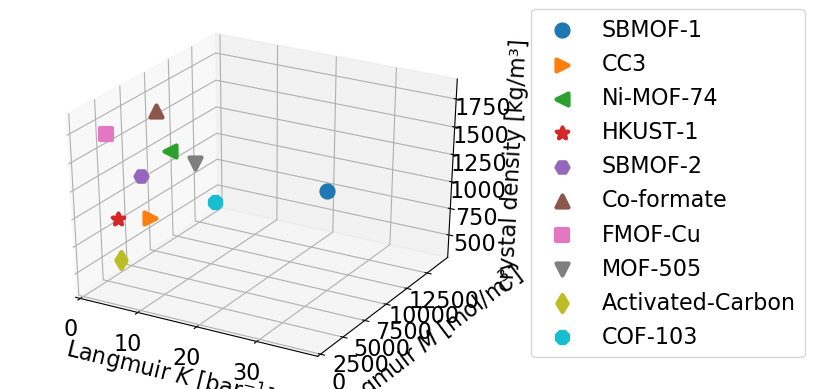

sys:1: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
sys:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
sys:1: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
sys:1: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
sys:1: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.


In [34]:
# figure(figsize=(5,5))
figure()
title("material Space")
for row in eachrow(df_crystal)
    scatter3D(row[:K_inv_bar], row[:M_mol_m3], row[:ρ_kg_m3], 
        label=row[:xtal], marker=mof_to_marker[row[:xtal]], s=75, clip_on=false, lw=3)
end

xlabel(L"Langmuir $K$ [bar$^{-1}$]", labelpad=6)
ylabel(L"Langmuir $M$ [mol/m$^3$]", labelpad=6)
zlabel("crystal density [kg/m³]", labelpad=6)
tight_layout()
ylim(ymin=0.0)
xlim(xmin=0.0)
lgd = legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

# savefig("material_space.pdf", format="pdf", bbox_inches="tight")

## viz Langmuir fits

TODO: give each MOF the same color

In [35]:
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["font.size"] = 16

In [36]:
function plot_mof_langmuir_fit(mof::String, max_pressure::Float64)
    
    # fitting plot
    figure()
    xlabel(L"pressure, $P$ [bar]")
    ylabel("xenon density [mol/m³]")
    title(mof)
    label="experiment"
    if mof == "COF-103"
        label="simulation"
    end
    scatter(xe_isotherms[mof][:, common_pressure_units], xe_isotherms[mof][:, common_loading_units],
        color=mof_to_color[mof], label=label)
    
    # Langmuir fit
    pressure_low = range(0.0, stop=max_pressure, length=500) # check with COF-103
    ρ_langmuir = (params_langmuir[mof]["M"] .* params_langmuir[mof]["K"] .* pressure_low) ./ (
                    1 .+ params_langmuir[mof]["K"] * pressure_low)
    plot(pressure_low, ρ_langmuir, color=mof_to_color[mof], label="Langmuir fit")
    
    # bulk gas density
    if max_pressure < 1.5
        plot(df_low_p_xe_data[:, Symbol("Pressure (bar)")], df_low_p_xe_data[:, Symbol("Density (mol/m³)")], 
            label="bulk gas", linestyle="--", color="gray")
    else 
        max_index = findfirst(df_xe_data[:, Symbol("Pressure (bar)")] .> max_pressure) # find the index of the max pressure in the dataframe
        plot(df_xe_data[1:max_index, Symbol("Pressure (bar)")], df_xe_data[1:max_index, Symbol("Density (mol/m³)")], 
            label="bulk gas", linestyle="--", color="gray")
    end
    
    grid("on")
    legend() 
end

plot_mof_langmuir_fit (generic function with 1 method)

### Low pressure fit

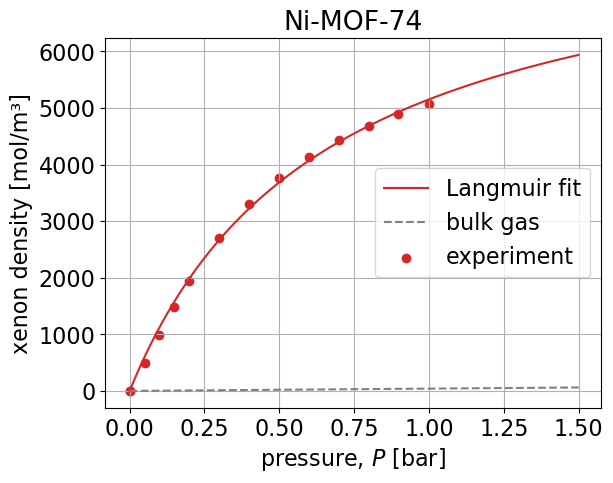

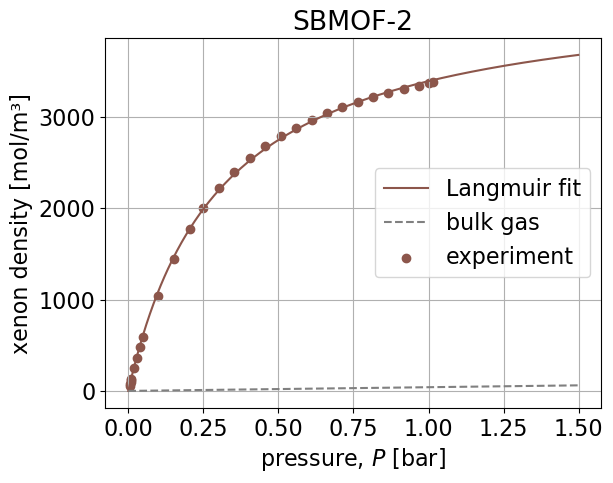

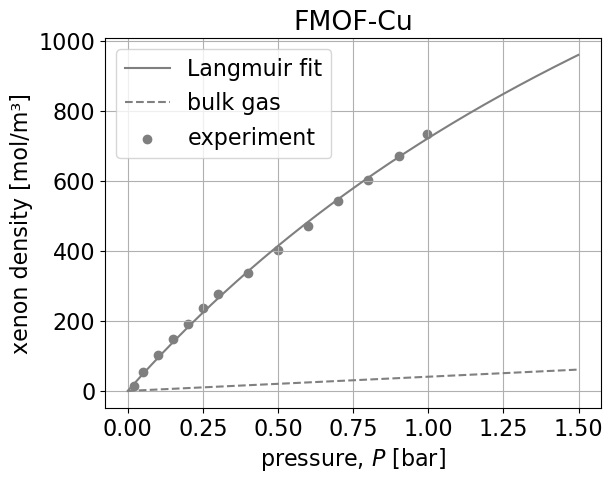

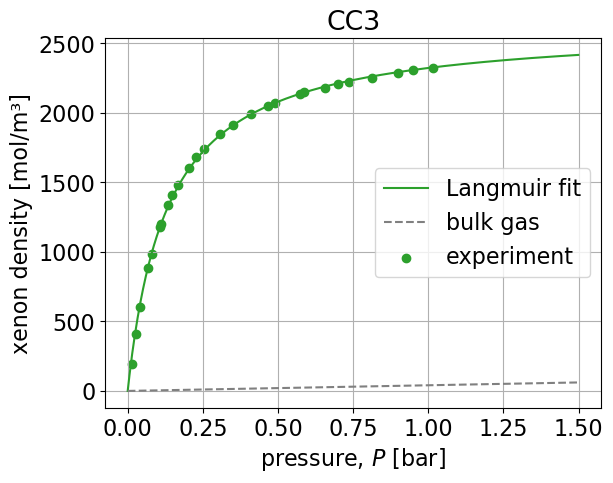

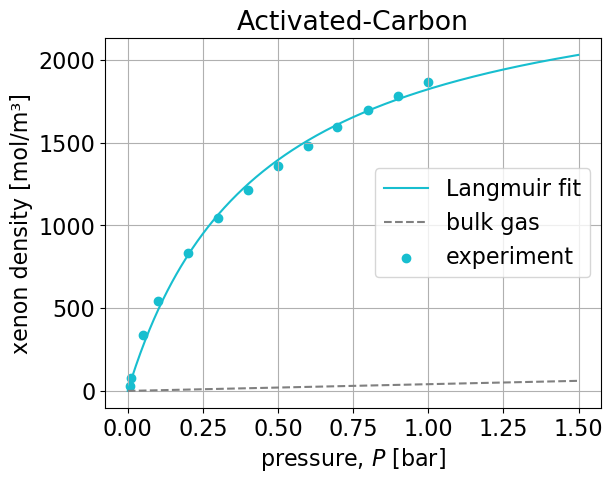

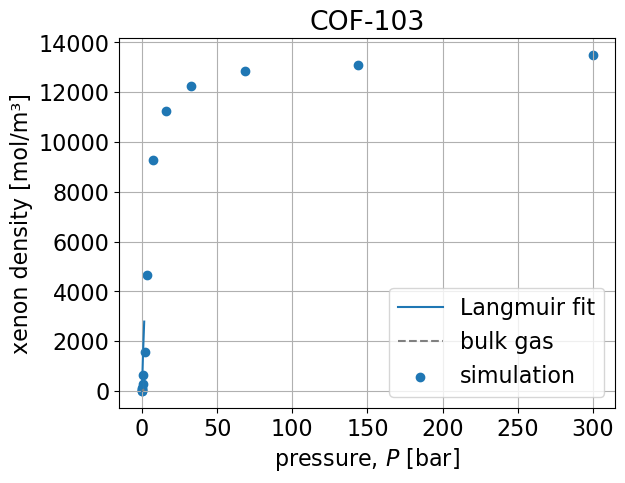

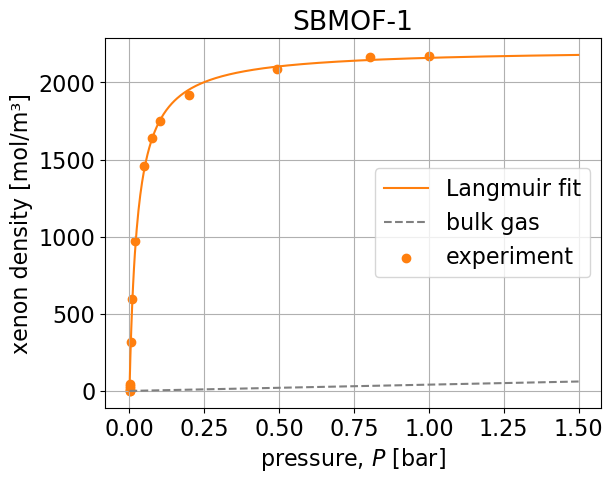

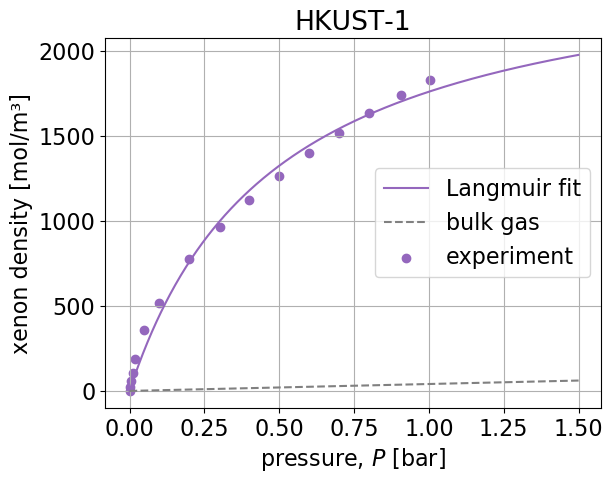

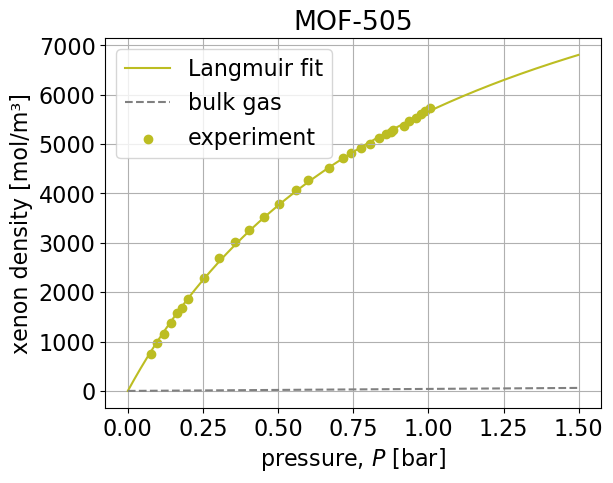

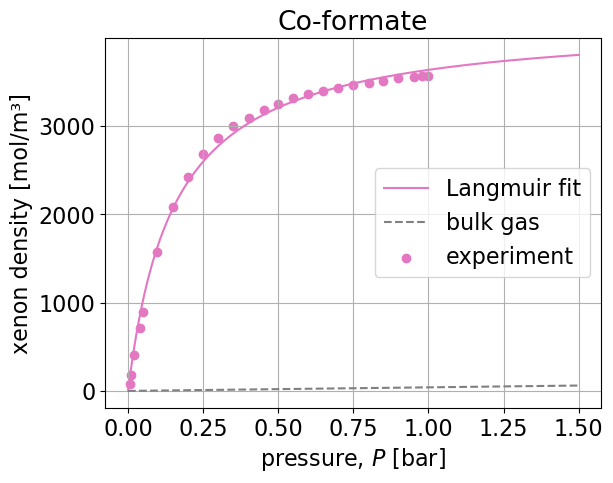

In [37]:
for mof in keys(xe_isotherms)
    plot_mof_langmuir_fit(mof, 1.499)
end

### High pressure fit

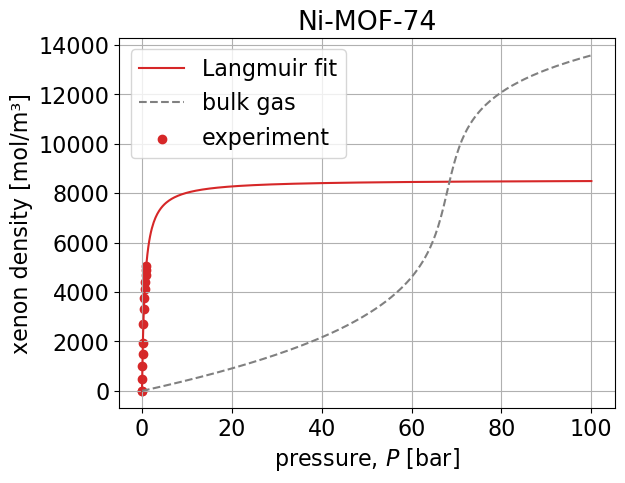

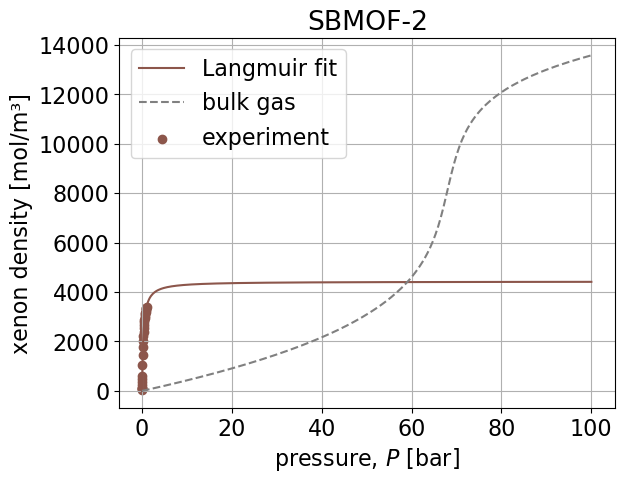

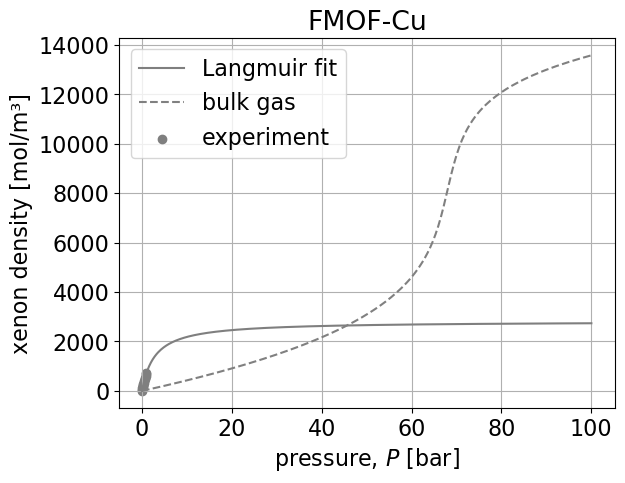

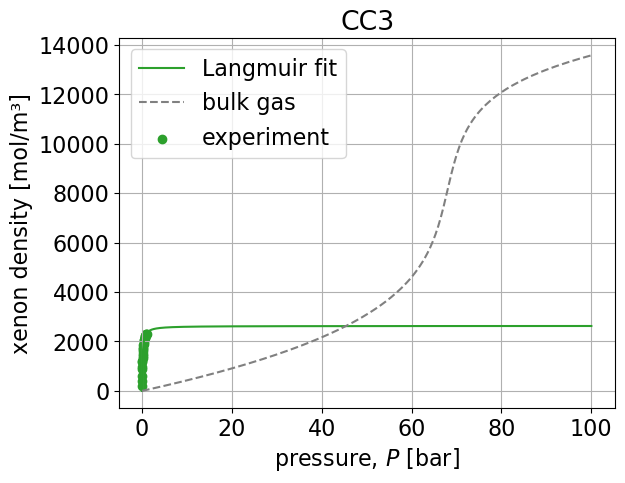

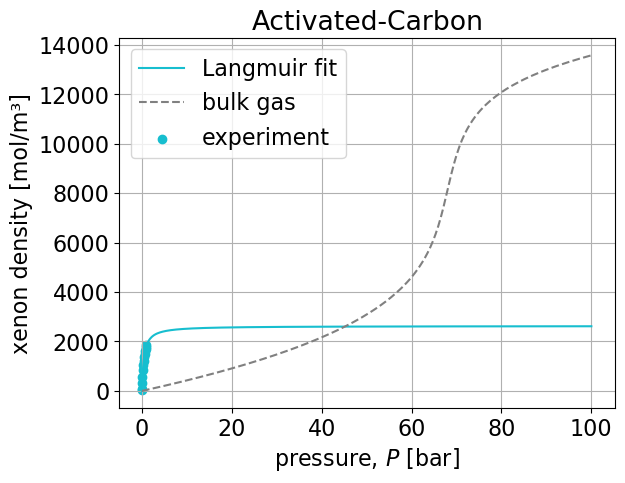

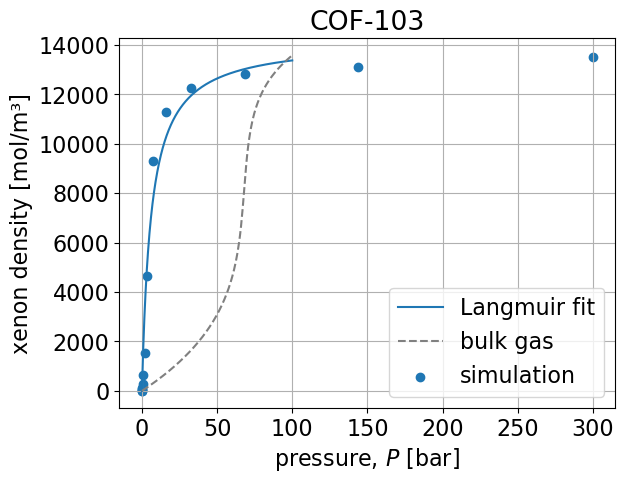

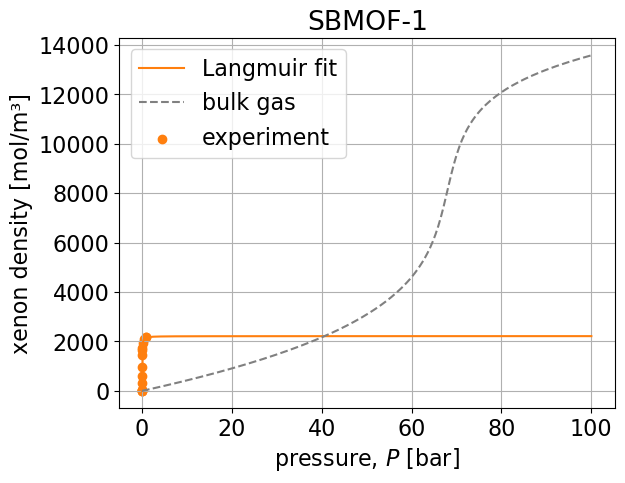

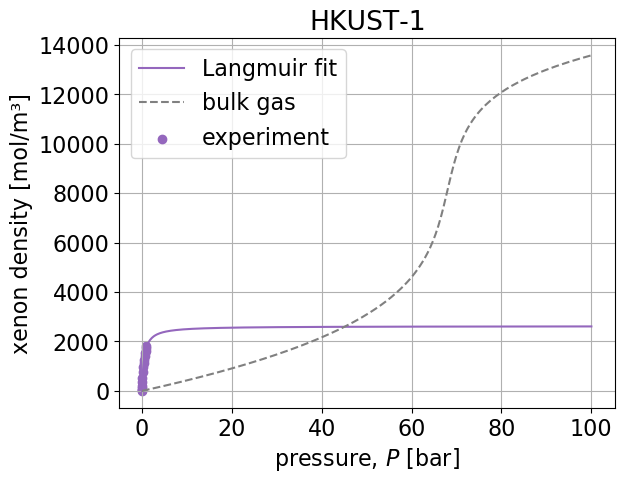

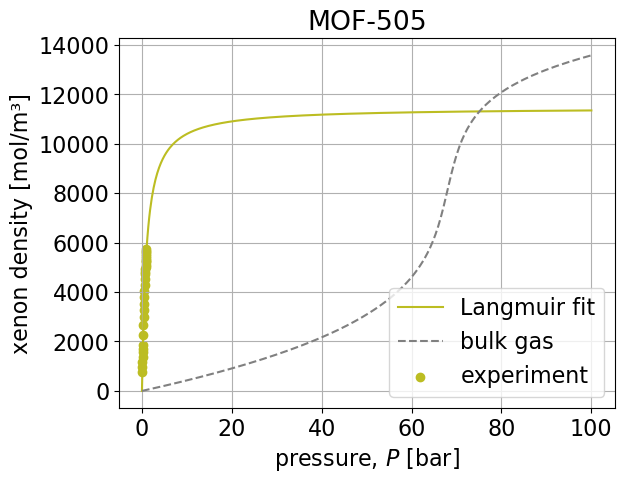

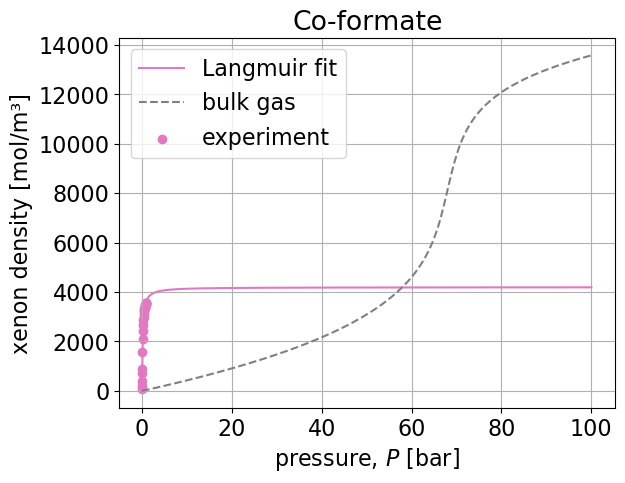

In [38]:
for mof in keys(xe_isotherms)
    plot_mof_langmuir_fit(mof, 100.0)
end